# BSNN Gesture

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! pip install tonic snntorch optuna --quiet

## Imports

In [1]:
import numpy as np
import numpy.lib.recfunctions as rf

import tonic
import tonic.transforms as transforms
from tonic.datasets import DVSGesture
from tonic import DiskCachedDataset

import matplotlib.pyplot as plt
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import functional as SF
from snntorch import surrogate

import optuna

import math

c:\Users\Vince\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'optuna'

## Configuration

In [4]:
config = {
    # Data Loading
    "data_path" : r"/content/drive/My Drive/Colab Notebooks", # Change this to your path
    "cache_path" : r"/content/drive/My Drive/Colab Notebooks/cache", # Change this to your path
    "batch_size": 32,

    # Transforms
    "w": 32,
    "h": 32,
    "n_frames": 32,
    "filter_time": 10_000,
    "is_debug": False,

    # SNN
    "beta": 0.41628667820177095,
    "thresh_1": 22.37297929074331,
    "thresh_2": 1.738555820352834,
    "thresh_3": 19.083022150261986,
    "dropout_1": 0.48143584931131816,
    "slope": 0.9870918226886212,

    # Training
    "n_epochs": 500,

    # Hyper Param Sweep
    "num_trials": 100,
    "lr": 0.07371864396198977,
    "num_steps": 100,
    "betas": (0.9, 0.99),

    # Loss function
    "correct_rate": 0.8,
    "incorrect_rate": 0.2,
    "is_batch_norm": False,

    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}


## Data Processing

### Normalization Function

In [5]:
# def normalize_frames(frames):
#     # Convert to numpy if it's a torch tensor
#     if isinstance(frames, torch.Tensor):
#         frames = frames.cpu().numpy()

#     # Normalize frames
#     frames_min = frames.min()
#     frames_max = frames.max()
#     normalized_frames = (frames - frames_min) / (frames_max - frames_min)

#     return normalized_frames


### To Frames

In [6]:
def to_frames(events):
     # creates dense frames from events by binning them in different ways
    frame_transform = tonic.transforms.ToFrame(
        sensor_size=tonic.datasets.DVSGesture.sensor_size,
        #time_window=10000)
        n_time_bins=100)
        #event_count=1000)
    return frame_transform(events)



### Load Data

In [7]:
def load_dataset(dataset_path, is_train):
    dataset = tonic.datasets.DVSGesture(save_to=dataset_path, train=is_train)
    return dataset

train = load_dataset(config["data_path"], True)
test = load_dataset(config["data_path"], False)


### Plot Data

In [ ]:
# Load a sample from the training dataset
events, label = train[0]

# Convert the events to frames
frames = to_frames(events)

print("Train dataset contains", len(train), "samples.")
print("There are", len(events), "events in the selected sample.")
print("A single event:", events[0], "as (x-pos, y-pos, polarity, timestamp).")
print(frames.shape, label)

# Visualize the normalized frames
#normalized_frames = normalize_frames(frames)
ani = tonic.utils.plot_animation(frames)
HTML(ani.to_jshtml())


### Reshape Data 32x32

In [ ]:
w = config["w"]
h = config["h"]
n_frames = config["n_frames"]
debug = config["is_debug"]
filter_time = config["filter_time"]


transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=filter_time), # removes outlier events with inactive surrounding pixels for 10ms
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(w,h)), # downsampling image
    tonic.transforms.ToFrame(sensor_size=(w,h,2), n_time_bins=n_frames), # n_frames frames per trail
])


train2 = DVSGesture(save_to=config["data_path"], train=True, transform=transforms)
test2 = DVSGesture(save_to=config["data_path"], train=False, transform=transforms)

cached_train = train2 if debug else DiskCachedDataset(train2, cache_path=config["cache_path"])
cached_test = test2 if debug else DiskCachedDataset(test2, cache_path=config["cache_path"])

frames, label = cached_train[0]
print(frames.shape, label)

#normalized_frames = normalize_frames(frames)
ani = tonic.utils.plot_animation(frames)
HTML(ani.to_jshtml())

## Binarization

### Binary Layers

In [10]:
class Binarize(Function):

    @staticmethod
    def forward(ctx, input):
        output = input.new(input.size())
        output[input >= 0] = 1
        output[input < 0] = -1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

binarize = Binarize.apply

In [11]:
class BinaryLinear(nn.Linear):

    def forward(self, input):
        binary_weight = binarize(self.weight)
        if self.bias is None:
            return F.linear(input, binary_weight)
        else:
            return F.linear(input, binary_weight, self.bias)

    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv

In [12]:
class BinaryConv2d(nn.Conv2d):

    def forward(self, input):
        bw = binarize(self.weight)
        return F.conv2d(input, bw, self.bias, self.stride,
                               self.padding, self.dilation, self.groups)

    def reset_parameters(self):
        # Glorot initialization
        in_features = self.in_channels
        out_features = self.out_channels
        for k in self.kernel_size:
            in_features *= k
            out_features *= k
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv


### BSNN Model

In [13]:
class BSNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.thr_1 = config["thresh_1"]
        self.thr_2 = config["thresh_2"]
        self.thr_3 = config["thresh_3"]
        self.beta = config["beta"]
        self.num_steps = config["num_steps"]
        self.is_batch_norm = config["is_batch_norm"]
        self.slope = config["slope"]
        self.spike_grad = snn.surrogate.fast_sigmoid(slope=self.slope) # surrogate.atan()
        do_per_1 = config["dropout_1"]


        self.bin_conv_1 = BinaryConv2d(in_channels=2, out_channels=16, kernel_size=5)
        self.batch_norm_1 = nn.BatchNorm2d(num_features=16)
        self.lif_1 = snn.Leaky(beta=self.beta, threshold=self.thr_1, spike_grad=self.spike_grad)

        self.bin_conv_2 = BinaryConv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.batch_norm_2 = nn.BatchNorm2d(num_features=32)
        self.lif_2 = snn.Leaky(beta=self.beta, threshold=self.thr_2, spike_grad=self.spike_grad)

        self.flatten = nn.Flatten()
        self.bin_fc_1 = BinaryLinear(in_features=800, out_features=11)
        self.do = nn.Dropout(do_per_1)
        self.lif_3 = snn.Leaky(beta=self.beta, threshold=self.thr_3, reset_mechanism="none")


    def forward(self, inpt):
        mem1 = self.lif_1.init_leaky()
        mem2 = self.lif_2.init_leaky()
        mem3 = self.lif_3.init_leaky()

        spk3_rec = []
        mem3_rec = []

        for step in range(inpt.size(0)):
            # print(f"inpt.shape: {inpt.shape}")

            current_step = inpt[step]

            cur1 = self.bin_conv_1(current_step)
            cur1 = F.avg_pool2d(cur1, 2)
            if self.is_batch_norm:
              cur1 = self.batch_norm_1(cur1)
            spk1, mem1 = self.lif_1(cur1, mem1)

            cur2 = self.bin_conv_2(spk1)
            cur2 = F.avg_pool2d(cur2, 2)
            if self.is_batch_norm:
              cur2 = self.batch_norm_2(cur2)
            spk2, mem2 = self.lif_2(cur2, mem2)

            cur3 = spk2.flatten(1)
            cur3 = self.bin_fc_1(cur3)
            cur3 = self.do(cur3)
            spk3, mem3 = self.lif_3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

## Train / Test Set-up

### Train Function

In [14]:
def train_model(model, train_loader, optimizer, device, loss_fn):
    # print(f"In train_model, device: {device}")

    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (data, targets) in enumerate(train_loader):

        # Assuming data is already a tensor or you have converted it as necessary
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        spk_rec, _ = model(data)

        # Compute loss
        loss = loss_fn(spk_rec, targets.long())
        total_loss += loss.item() * data.size(0)  # Accumulate total loss

        # Calculate accuracy
        total_spikes = spk_rec.sum(dim=0)
        preds = total_spikes.argmax(dim=1)

        # print(f"pred: {preds}\ntargets: {targets}\n")


        total_correct += (preds == targets).sum().item()
        total_samples += data.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average loss and accuracy over the epoch
    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples

    print(f"Training - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%")
    return epoch_loss, epoch_acc



### Validate Function

In [15]:
def validate_model(model, test_loader, device, loss_fn):
    model.eval()
    test_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, targets in test_loader:

            data = data.to(device)
            targets = targets.to(device)

            output, _ = model(data)

            # Compute loss using prepared targets
            test_loss += loss_fn(output, targets).item() * data.size(0)  # Multiply by batch size

            # Sum spikes over time to get total spikes per neuron/class
            total_spikes = output.sum(dim=0)  # Adjust dim as per your output's shape
            pred = total_spikes.argmax(dim=1)  # Predicted class based on max spike count

            # Calculate accuracy using original class labels
            total_correct += (pred == targets).sum().item()
            total_samples += data.size(0)

    test_loss /= total_samples
    accuracy = total_correct / total_samples

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")


### Train / Test Loaders

In [16]:
train_loader = DataLoader(cached_train, batch_size=config["batch_size"], shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(cached_test, batch_size=config["batch_size"], shuffle=False, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))

### Define device, model, optimizer, loss

In [17]:
device = config["device"]
print(f"device: {device}")

model = BSNN(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], betas=config["betas"])
loss_fn = SF.mse_count_loss(correct_rate=config["correct_rate"], incorrect_rate=config["incorrect_rate"])

device: cuda


## Execute Training

In [18]:
num_epochs = config["n_epochs"]
train_losses, train_accuracies = [], []
highest_acc = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_model(model, train_loader, optimizer, device, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    if train_acc > highest_acc:
        highest_acc = train_acc
        torch.save(model.state_dict(), "bsnn_gesture_model.pth")
        print(f"\nNew high accuracy of {train_acc*100:.2f}% achieved, model saved\n")

model.load_state_dict(torch.load("bsnn_gesture_model.pth"))
validate_model(model, test_loader, device, loss_fn)


Epoch 1/500
Training - Loss: 3.1729, Accuracy: 12.59%

New high accuracy of 12.59% achieved, model saved

Epoch 2/500
Training - Loss: 2.6786, Accuracy: 15.25%

New high accuracy of 15.25% achieved, model saved

Epoch 3/500
Training - Loss: 2.5680, Accuracy: 16.67%

New high accuracy of 16.67% achieved, model saved

Epoch 4/500
Training - Loss: 2.5910, Accuracy: 19.79%

New high accuracy of 19.79% achieved, model saved

Epoch 5/500
Training - Loss: 2.2542, Accuracy: 26.99%

New high accuracy of 26.99% achieved, model saved

Epoch 6/500
Training - Loss: 2.0057, Accuracy: 31.53%

New high accuracy of 31.53% achieved, model saved

Epoch 7/500
Training - Loss: 1.8766, Accuracy: 34.94%

New high accuracy of 34.94% achieved, model saved

Epoch 8/500
Training - Loss: 1.6872, Accuracy: 40.62%

New high accuracy of 40.62% achieved, model saved

Epoch 9/500
Training - Loss: 1.6425, Accuracy: 44.41%

New high accuracy of 44.41% achieved, model saved

Epoch 10/500
Training - Loss: 1.4937, Accuracy

## Plotting

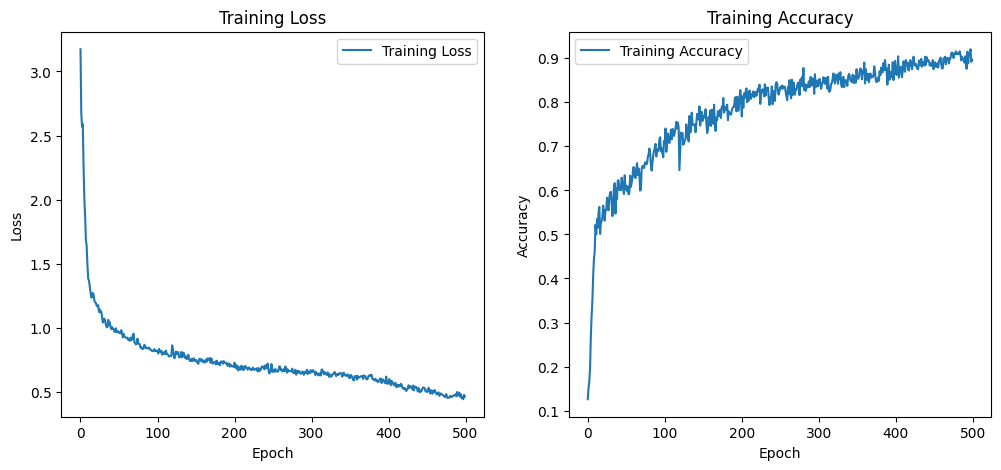

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Hyperparameter Tuning

In [19]:
# def objective(trial):
#     config["thresh_1"] = trial.suggest_float("thresh_1", 1, 30)
#     config["thresh_2"] = trial.suggest_float("thresh_2", 1, 30)
#     config["thresh_3"] = trial.suggest_float("thresh_3", 1, 30)
#     config["beta"] = trial.suggest_float("beta", 0.1, 0.9)
#     config["lr"] = trial.suggest_float("lr", 1e-10, 1e-1)
#     config["slope"] = trial.suggest_float("slope", 0.1, 50)
#     config["dropout_1"] = trial.suggest_float("dropout_1", 0.01, 0.9)



#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     # print(f"device: {device}")

#     model = BSNN(config).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
#     loss_fn = SF.mse_count_loss(correct_rate=config["correct_rate"], incorrect_rate=config["incorrect_rate"])

#     for epoch in range(config["n_epochs"]):
#         train_loss, train_acc = train_model(model, train_loader, optimizer, device, loss_fn)

#     return train_acc

In [20]:
# def run_study():
#     study_name = "bsnn_gesture_study"
#     storage_name = "sqlite:///{}.db".format(study_name)

#     study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="maximize")
#     study.optimize(objective, n_trials=config["num_trials"])

#     study.trials_dataframe().to_csv("study_results.csv")

#     print("Study statistics: ")
#     print("  Number of finished trials: ", len(study.trials))
#     print("  Best trial:")
#     trial = study.best_trial
#     print("    Value: ", trial.value)
#     print("    Params: ")
#     for key, value in trial.params.items():
#         print(f"      {key}: {value}")

In [21]:
# run_study()